In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [13]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 14-39-39.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 14-39-39_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_06.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752262808.724472 22513475 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1752262808.734130 23696426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752262808.739291 23696426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752262808.843358 23696431 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Detected FPS from PyAV: 60.0
-------- Detection Report --------
Total frames: 16770
Frames with at least 1 hand detected: 11046
Detection rate: 65.87%


In [6]:
df = pd.read_csv("hand_landmarks_06.csv")

print("Shape:", df.shape)
df

Shape: (519498, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,0.674460,0.568730,-1.942100e-07,1
1,0,0.000000,Left,1,0.674442,0.497234,-2.004554e-02,1
2,0,0.000000,Left,2,0.652166,0.431682,-2.271513e-02,1
3,0,0.000000,Left,3,0.612435,0.408546,-2.470886e-02,1
4,0,0.000000,Left,4,0.579687,0.417737,-2.630467e-02,1
...,...,...,...,...,...,...,...,...
519493,16769,279.516667,Right,16,NaN,NaN,NaN,0
519494,16769,279.516667,Right,17,NaN,NaN,NaN,0
519495,16769,279.516667,Right,18,NaN,NaN,NaN,0
519496,16769,279.516667,Right,19,NaN,NaN,NaN,0


In [9]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [12]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000,Left,1,0.674460,0.674442,0.652166,0.612435,0.579687,0.619217,...,-0.027421,-0.034000,0.012890,-0.012835,-0.026363,-0.027663,0.012305,-0.009537,-0.018487,-0.019318
1,1,0.017,Left,1,0.672644,0.680162,0.661893,0.619921,0.581079,0.644718,...,-0.054397,-0.059755,-0.005270,-0.035206,-0.045787,-0.044828,-0.000924,-0.027761,-0.037213,-0.037839
2,2,0.033,Left,1,0.675076,0.679679,0.667339,0.626948,0.587714,0.645473,...,-0.038525,-0.042189,-0.000502,-0.026302,-0.032754,-0.029481,-0.000346,-0.020988,-0.024538,-0.021700
3,3,0.050,Left,1,0.680411,0.680877,0.667648,0.626677,0.586852,0.646329,...,-0.037474,-0.041256,0.003357,-0.022086,-0.028831,-0.025711,0.004888,-0.014890,-0.018664,-0.015930
4,4,0.067,Left,1,0.681032,0.681970,0.667889,0.625218,0.584765,0.643836,...,-0.031888,-0.036658,0.009277,-0.016172,-0.024797,-0.022918,0.010564,-0.010418,-0.016491,-0.015286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12091,16736,278.933,Left,1,0.167581,0.149232,0.137298,0.130810,0.124856,0.145254,...,-0.010389,-0.009363,-0.009592,-0.011227,-0.009608,-0.008072,-0.011142,-0.011601,-0.008855,-0.006304
12092,16737,278.950,Left,1,0.146645,0.128622,0.119186,0.114997,0.111203,0.125935,...,-0.002115,-0.001060,-0.001738,-0.003145,-0.003104,-0.002222,-0.003916,-0.005157,-0.004785,-0.003696
12093,16738,278.967,Left,1,0.144768,0.127988,0.117174,0.110880,0.104927,0.123809,...,-0.011283,-0.011387,-0.007649,-0.010764,-0.011685,-0.011443,-0.009899,-0.012902,-0.012923,-0.011904
12094,16739,278.983,Left,1,0.118320,0.099518,0.089086,0.085703,0.084532,0.101725,...,0.002070,0.002597,0.001404,0.001311,0.002631,0.004000,-0.000184,0.000584,0.002704,0.004694


In [16]:
df2 = pd.read_csv("hand_lable_06.csv")

print("Shape:", df.shape)
df2

Shape: (519498, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,hold,NaN,START,0.000,D:/Data Science/UOB/DS_project/Full Study/06/2...,0,NaN,NaN
1,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,hold,NaN,STOP,10.567,D:/Data Science/UOB/DS_project/Full Study/06/2...,634,NaN,NaN
2,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,other,NaN,START,10.583,D:/Data Science/UOB/DS_project/Full Study/06/2...,635,NaN,NaN
3,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,other,NaN,STOP,27.133,D:/Data Science/UOB/DS_project/Full Study/06/2...,1628,NaN,NaN
4,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,hold,NaN,START,27.150,D:/Data Science/UOB/DS_project/Full Study/06/2...,1629,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,press,NaN,STOP,263.700,D:/Data Science/UOB/DS_project/Full Study/06/2...,15822,NaN,NaN
216,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,hold,NaN,START,263.717,D:/Data Science/UOB/DS_project/Full Study/06/2...,15823,NaN,NaN
217,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,hold,NaN,STOP,264.283,D:/Data Science/UOB/DS_project/Full Study/06/2...,15857,NaN,NaN
218,6,2025-07-09 22:35:40.696,NaN,264.65,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,279.5,60.0,NaN,press,NaN,START,264.300,D:/Data Science/UOB/DS_project/Full Study/06/2...,15858,NaN,NaN


In [19]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,hold,0.000,10.567,0,634
1,other,10.583,27.133,635,1628
2,hold,27.150,41.817,1629,2509
3,place,41.833,43.517,2510,2611
4,lift,46.350,47.350,2781,2841
...,...,...,...,...,...
105,press,262.200,262.583,15732,15755
106,hold,262.600,263.233,15756,15794
107,press,263.250,263.700,15795,15822
108,hold,263.717,264.283,15823,15857


In [22]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_21417/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'hold' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Left,1,0.674460,0.674442,0.652166,0.612435,0.579687,0.619217,...,-0.034000,0.012890,-0.012835,-0.026363,-0.027663,0.012305,-0.009537,-0.018487,-0.019318,hold
1,1,0.017,Left,1,0.672644,0.680162,0.661893,0.619921,0.581079,0.644718,...,-0.059755,-0.005270,-0.035206,-0.045787,-0.044828,-0.000924,-0.027761,-0.037213,-0.037839,hold
2,2,0.033,Left,1,0.675076,0.679679,0.667339,0.626948,0.587714,0.645473,...,-0.042189,-0.000502,-0.026302,-0.032754,-0.029481,-0.000346,-0.020988,-0.024538,-0.021700,hold
3,3,0.050,Left,1,0.680411,0.680877,0.667648,0.626677,0.586852,0.646329,...,-0.041256,0.003357,-0.022086,-0.028831,-0.025711,0.004888,-0.014890,-0.018664,-0.015930,hold
4,4,0.067,Left,1,0.681032,0.681970,0.667889,0.625218,0.584765,0.643836,...,-0.036658,0.009277,-0.016172,-0.024797,-0.022918,0.010564,-0.010418,-0.016491,-0.015286,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12091,16736,278.933,Left,1,0.167581,0.149232,0.137298,0.130810,0.124856,0.145254,...,-0.009363,-0.009592,-0.011227,-0.009608,-0.008072,-0.011142,-0.011601,-0.008855,-0.006304,NaN
12092,16737,278.950,Left,1,0.146645,0.128622,0.119186,0.114997,0.111203,0.125935,...,-0.001060,-0.001738,-0.003145,-0.003104,-0.002222,-0.003916,-0.005157,-0.004785,-0.003696,NaN
12093,16738,278.967,Left,1,0.144768,0.127988,0.117174,0.110880,0.104927,0.123809,...,-0.011387,-0.007649,-0.010764,-0.011685,-0.011443,-0.009899,-0.012902,-0.012923,-0.011904,NaN
12094,16739,278.983,Left,1,0.118320,0.099518,0.089086,0.085703,0.084532,0.101725,...,0.002597,0.001404,0.001311,0.002631,0.004000,-0.000184,0.000584,0.002704,0.004694,NaN


In [25]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
hold      3646
rotate    3576
adjust    1773
other     1674
NaN        661
press      303
place      240
lift       223
Name: count, dtype: int64


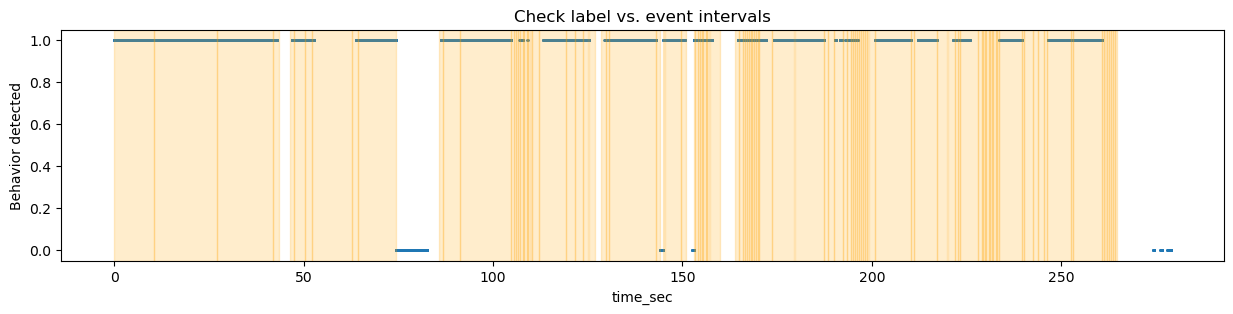

In [28]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [33]:
df_wide[(df_wide['time_sec'] <= 47.367)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,hold
1,0.017,hold
2,0.033,hold
3,0.050,hold
4,0.067,hold
...,...,...
3172,47.300,lift
3173,47.317,lift
3174,47.333,lift
3175,47.350,lift


In [87]:
df_wide[(df_wide['time_sec'] <= 193.05)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,hold
1,0.017,hold
2,0.033,hold
3,0.050,hold
4,0.067,hold
...,...,...
9616,192.067,other
9617,192.083,other
9618,192.100,other
9619,193.033,lift


In [112]:
df_wide[(df_wide['time_sec'] <= 270.25)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,hold
1,0.017,hold
2,0.033,hold
3,0.050,hold
4,0.067,hold
...,...,...
11989,260.767,rotate
11990,260.783,rotate
11991,260.800,rotate
11992,260.817,rotate


In [91]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Left,1,0.674460,0.674442,0.652166,0.612435,0.579687,0.619217,...,-0.034000,0.012890,-0.012835,-0.026363,-0.027663,0.012305,-0.009537,-0.018487,-0.019318,hold
1,1,0.017,Left,1,0.672644,0.680162,0.661893,0.619921,0.581079,0.644718,...,-0.059755,-0.005270,-0.035206,-0.045787,-0.044828,-0.000924,-0.027761,-0.037213,-0.037839,hold
2,2,0.033,Left,1,0.675076,0.679679,0.667339,0.626948,0.587714,0.645473,...,-0.042189,-0.000502,-0.026302,-0.032754,-0.029481,-0.000346,-0.020988,-0.024538,-0.021700,hold
3,3,0.050,Left,1,0.680411,0.680877,0.667648,0.626677,0.586852,0.646329,...,-0.041256,0.003357,-0.022086,-0.028831,-0.025711,0.004888,-0.014890,-0.018664,-0.015930,hold
4,4,0.067,Left,1,0.681032,0.681970,0.667889,0.625218,0.584765,0.643836,...,-0.036658,0.009277,-0.016172,-0.024797,-0.022918,0.010564,-0.010418,-0.016491,-0.015286,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,15646,260.767,Right,1,0.280556,0.320191,0.342358,0.369985,0.401708,0.278804,...,-0.027577,0.015344,0.012676,0.006636,0.001861,0.045247,0.040321,0.034472,0.031184,rotate
11990,15647,260.783,Right,1,0.244238,0.281559,0.306096,0.334165,0.359625,0.234482,...,-0.086425,-0.024462,-0.047058,-0.055706,-0.058050,-0.011347,-0.028049,-0.035273,-0.036985,rotate
11991,15648,260.800,Right,1,0.242462,0.280487,0.305548,0.333246,0.355193,0.233348,...,-0.079453,-0.016052,-0.037258,-0.046851,-0.049226,0.000032,-0.016531,-0.024042,-0.025280,rotate
11992,15649,260.817,Left,1,0.259253,0.290332,0.304994,0.326578,0.339125,0.221076,...,-0.040246,-0.026848,-0.046694,-0.045448,-0.039846,-0.049351,-0.061089,-0.056841,-0.051219,rotate


In [97]:
df_wide['dataset_id'] = '06'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,06,0,0.000,Left,1,0.674460,0.674442,0.652166,0.612435,0.579687,...,-0.034000,0.012890,-0.012835,-0.026363,-0.027663,0.012305,-0.009537,-0.018487,-0.019318,hold
1,06,1,0.017,Left,1,0.672644,0.680162,0.661893,0.619921,0.581079,...,-0.059755,-0.005270,-0.035206,-0.045787,-0.044828,-0.000924,-0.027761,-0.037213,-0.037839,hold
2,06,2,0.033,Left,1,0.675076,0.679679,0.667339,0.626948,0.587714,...,-0.042189,-0.000502,-0.026302,-0.032754,-0.029481,-0.000346,-0.020988,-0.024538,-0.021700,hold
3,06,3,0.050,Left,1,0.680411,0.680877,0.667648,0.626677,0.586852,...,-0.041256,0.003357,-0.022086,-0.028831,-0.025711,0.004888,-0.014890,-0.018664,-0.015930,hold
4,06,4,0.067,Left,1,0.681032,0.681970,0.667889,0.625218,0.584765,...,-0.036658,0.009277,-0.016172,-0.024797,-0.022918,0.010564,-0.010418,-0.016491,-0.015286,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,06,15646,260.767,Right,1,0.280556,0.320191,0.342358,0.369985,0.401708,...,-0.027577,0.015344,0.012676,0.006636,0.001861,0.045247,0.040321,0.034472,0.031184,rotate
11990,06,15647,260.783,Right,1,0.244238,0.281559,0.306096,0.334165,0.359625,...,-0.086425,-0.024462,-0.047058,-0.055706,-0.058050,-0.011347,-0.028049,-0.035273,-0.036985,rotate
11991,06,15648,260.800,Right,1,0.242462,0.280487,0.305548,0.333246,0.355193,...,-0.079453,-0.016052,-0.037258,-0.046851,-0.049226,0.000032,-0.016531,-0.024042,-0.025280,rotate
11992,06,15649,260.817,Left,1,0.259253,0.290332,0.304994,0.326578,0.339125,...,-0.040246,-0.026848,-0.046694,-0.045448,-0.039846,-0.049351,-0.061089,-0.056841,-0.051219,rotate


In [114]:
df_wide.to_csv("handlandmark_wide_06.csv", index=False)